In [1]:
import numpy as np
import pandas as pd
import healpy as hp
%config InlineBackend.figure_format = 'retina'
from DS_Planck_Unet import west_val, east_val
from matplotlib import pyplot as plt
from DS_Planck_Unet import load_planck_model, draw_pic_with_mask, draw_pic, val_pix
from DS_healpix_fragmentation import *
from DS_data_transformation import pic2fits, normalize
from DS_detector import *
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from DS_data_transformation import normalize
import seaborn as sns
from scipy.special import logit
from DS_models_stat import stat_orig_cats, do_all_stats
from DS_detector import rematch_cat
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from DS_healpix_fragmentation import cut_cat_by_pix

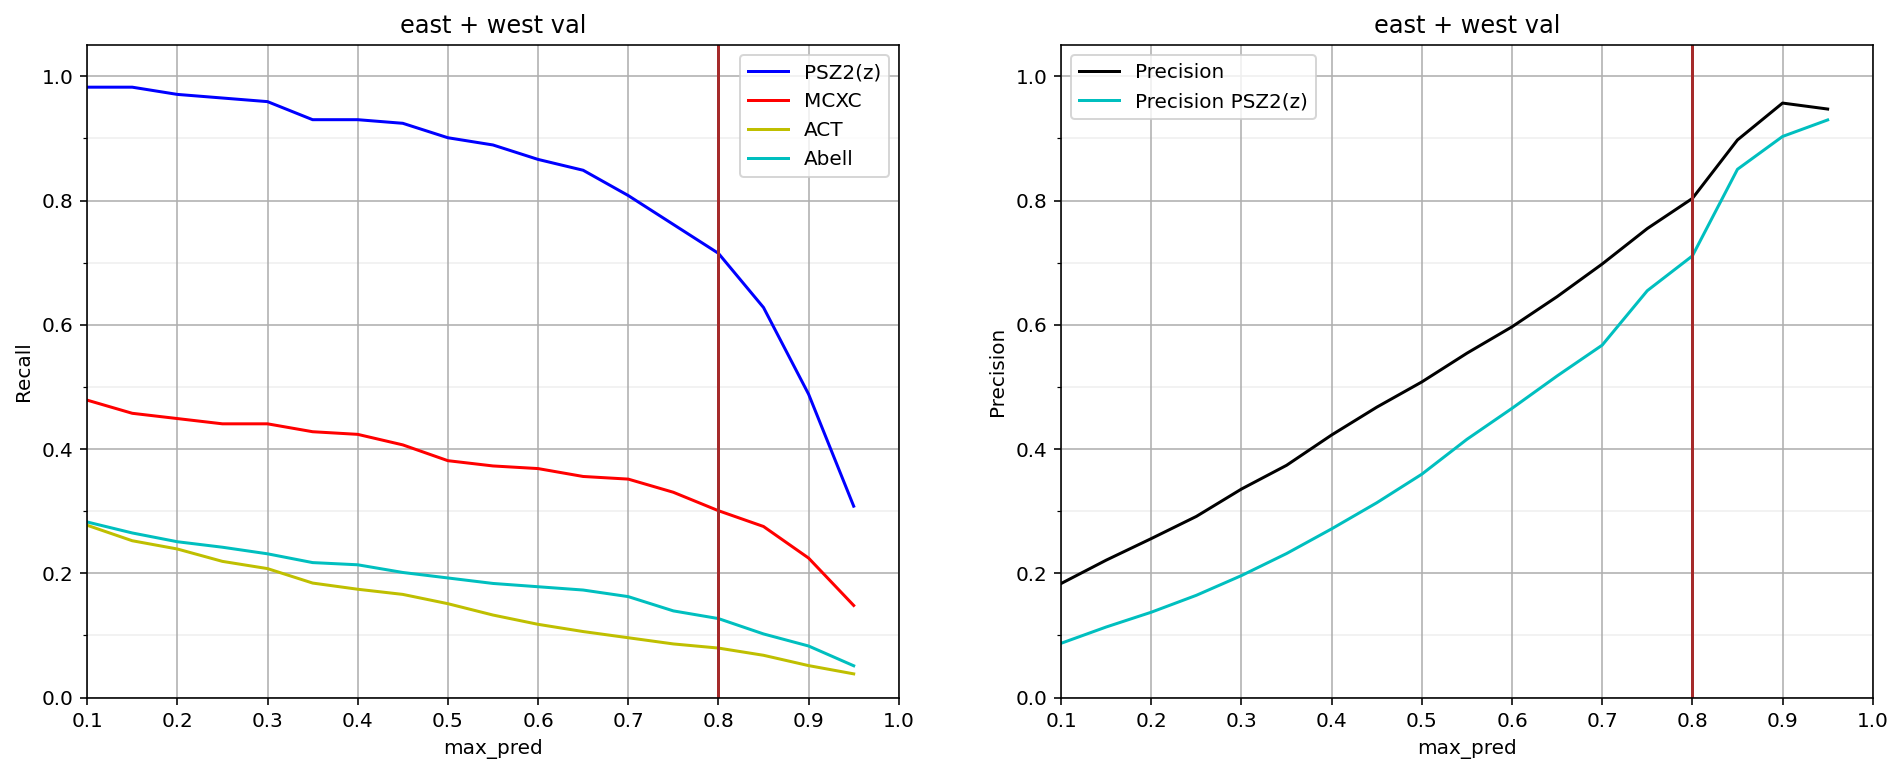

In [10]:
recall_df = pd.read_csv('./check/all_found34_recall_max_pred_pixwe.csv', index_col='max_pred')
_, ax = plt.subplots(1, 2, figsize=(16, 6))
for c, name in zip('brycg', ['planck_z', 'MCXC', 'ACT', 'Abell']):
    s, = ax[0].plot(recall_df.index, recall_df[name], c=c)
    if name == 'planck_z':
        name = 'PSZ2(z)'
    s.set_label(name)
ax[0].set_ylabel('Recall')
s, = ax[1].plot(recall_df.index, recall_df['precision'], c='k')
s.set_label('Precision')
ax[1].set_ylabel('Precision')
s, = ax[1].plot(recall_df.index, recall_df['precision_planck_z'], c='c')
s.set_label('Precision PSZ2(z)')

for i in range(2):
    ax[i].axvline(0.8, c='brown')
    ax[i].set_xlim(0.1, 1)
    ax[i].set_ylim(0, 1.05)
    ax[i].set_xlabel('max_pred')
    ax[i].set_title('east + west val')
    ax[i].set_xticks(np.arange(0.1, 1, 0.1), minor=True)
    ax[i].set_yticks(np.arange(0.1, 1, 0.1), minor=True)
    ax[i].grid(True, axis='both', which='major')
    ax[i].grid(True, axis='both', which='minor', alpha=0.2)
    ax[i].legend()


In [7]:
def stat_orig_cats_simple(det_cats_dict, big_pix=None, true_cats_dir='./check/true_clusters/', match_dist=5/60, read_det_files=True, 
                         excl_cats=[], spec_precision=[]):
    import os
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    import numpy as np
    import pandas as pd
    
    
    true_cats_files = next(os.walk(true_cats_dir))[-1]
    true_cats_files = [os.path.join(true_cats_dir, file) for file in true_cats_files]
    
    true_cats = {os.path.splitext(os.path.basename(file))[0] : pd.read_csv(file) for file in true_cats_files}
    true_cats = {tr_cat_name : true_cats[tr_cat_name] for tr_cat_name in true_cats if not (tr_cat_name in excl_cats)}
    det_cats = det_cats_dict
    if read_det_files:
        det_cats = {name : 
                pd.read_csv(det_cats_dict[name]) for name in det_cats_dict}
    
    recall_df = []
    if not (big_pix is None):
        for tr_name in true_cats:
            true_cats[tr_name] = cut_cat_by_pix(true_cats[tr_name], big_pix)
        for name in det_cats:
            det_cats[name] = cut_cat_by_pix(det_cats[name], big_pix)
    
    for name in det_cats:
        df = det_cats[name]
        df = df[df['status'] != 'fn']
        df.index = np.arange(len(df))
        df['found'] = False
        det_cats[name] = df
        
    
    for det_name in det_cats:
        det = det_cats[det_name]
        line_r = do_all_stats(det, true_cats, match_dist=match_dist, spec_precision=spec_precision)
        recall_df.append(pd.DataFrame(line_r, index=[det_name]))
    
    recall_df = pd.concat(recall_df)
    return recall_df

In [4]:
def cut_max_pred(cat, max_pred):
    df = cat.copy()
    df = df[df['max_pred'] >= max_pred]
    df.index = np.arange(len(df))
    return df

In [8]:
det_cat = pd.read_csv('./check/full_pz_all_found34_thr0.1_step8_no_fn.csv')
cat_d = {max_pred_prm : cut_max_pred(det_cat, max_pred_prm) for max_pred_prm in np.arange(0.1, 1, 0.05)}
recall_df = stat_orig_cats_simple(cat_d, big_pix=east_val + west_val, read_det_files=False, match_dist=400/3600, 
                                 spec_precision=['planck_z'])
recall_df = recall_df.sort_index()
recall_df.index.name='max_pred'
recall_df.to_csv('./check/all_found34_recall_max_pred_pixwe.csv')

In [5]:
df = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv')

In [6]:
df = cut_cat_by_pix(df, east_val + west_val)

In [7]:
np.count_nonzero(df['catalog'] == 'planck_z') / len(df)

0.08535954474909467

In [32]:
recall_df

,planck_z,MCXC,eRosita,ACT,Abell,precision,precision_check,precision_pz,all
max_pred,,,,,,,,,
0.10,0.977778,0.423077,0.977778,0.213740,0.267658,0.165882,0.162353,0.001150,850
0.15,0.977778,0.400000,0.977778,0.198473,0.256506,0.202723,0.201210,0.001479,661
0.20,0.955556,0.384615,0.955556,0.190840,0.245353,0.231330,0.231330,0.001741,549
0.25,0.944444,0.384615,0.944444,0.175573,0.234201,0.265217,0.269565,0.002053,460
0.30,0.944444,0.384615,0.944444,0.175573,0.223048,0.310705,0.318538,0.002466,383
0.35,0.922222,0.376923,0.922222,0.160305,0.211896,0.346875,0.356250,0.002882,320
0.40,0.922222,0.376923,0.922222,0.152672,0.208178,0.392086,0.402878,0.003317,278
0.45,0.922222,0.369231,0.922222,0.152672,0.204461,0.451477,0.464135,0.003891,237
0.50,0.900000,0.346154,0.900000,0.129771,0.193309,0.483092,0.497585,0.004348,207


In [33]:
5/60, 400/3600

(0.08333333333333333, 0.1111111111111111)